<a href="https://colab.research.google.com/github/aniket-alt/crispdm-kdd-semma-ds/blob/main/project_2_kdd_house_prices/house_price_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
✅ Data selected and loaded successfully!
Dataset has 1460 rows and 81 columns.

--- Initial Data Head ---
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    A

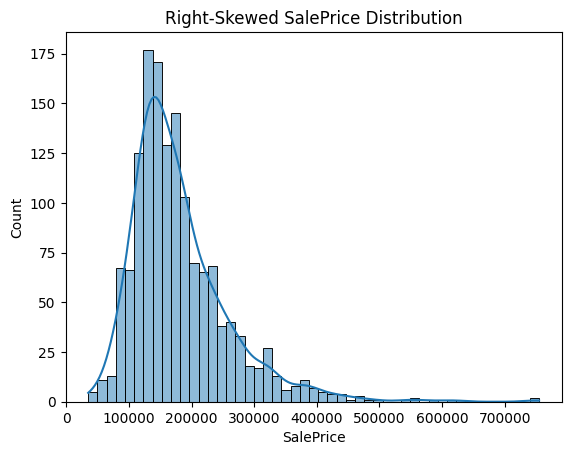

In [1]:
# Cell 1: Mount Drive, Install Libraries, and Load Data

# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# --- 2. Mount Google Drive ---
drive.mount('/content/drive')

# --- 3. KDD Step 1: Selection ---
# We select our data source (train.csv) and our target (SalePrice).
file_path = '/content/drive/My Drive/Coursework/Data Mining/Assignments/KDD/train.csv'

try:
    df = pd.read_csv(file_path)
    print("✅ Data selected and loaded successfully!")
    print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")
    print("\n--- Initial Data Head ---")
    print(df.head())
    print("\n--- Target Variable 'SalePrice' Distribution (Before Transform) ---")
    sns.histplot(df['SalePrice'], kde=True)
    plt.title('Right-Skewed SalePrice Distribution')
    plt.show()
except FileNotFoundError:
    print(f"❌ ERROR: File not found at the path: {file_path}")
    print("Please make sure 'train.csv' is in your main 'My Drive' folder.")

In [2]:
# Cell 2: KDD Step 2: Pre-processing (Cleaning the Data)
print("--- KDD Step 2: Pre-processing ---")

# We will clean the data as defined in our KDD article.

# 1. Handle Categorical 'NaN': Fill with 'None'
# These are features where 'NaN' has a real meaning (e.g., "No Pool")
features_na_as_none = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]
for col in features_na_as_none:
    if col in df.columns:
        df[col] = df[col].fillna('None')

print(f"✅ Categorical 'NaN' values imputed with 'None'.")

# 2. Handle Numerical 'NaN': Fill with median
# These are "true" missing values. We use the median to avoid outlier skew.
numerical_na_features = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']
for col in numerical_na_features:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

print(f"✅ Numerical 'NaN' values imputed with median.")

# 3. Handle other 'NaN' (e.g., 'Electrical'): Fill with mode (most common value)
other_na_cols = df.select_dtypes(include='object').columns[df.select_dtypes(include='object').isnull().any()].tolist()
for col in other_na_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print(f"✅ Other remaining 'NaN' values imputed with mode.")

# 4. Check if all missing values are handled
missing_count = df.isnull().sum().sum()
if missing_count == 0:
    print("🎉 All missing values have been pre-processed!")
else:
    print(f"⚠️ Warning: {missing_count} missing values still remain.")

--- KDD Step 2: Pre-processing ---
✅ Categorical 'NaN' values imputed with 'None'.
✅ Numerical 'NaN' values imputed with median.
✅ Other remaining 'NaN' values imputed with mode.
🎉 All missing values have been pre-processed!


In [3]:
# Cell 3: KDD Step 3: Transformation (Feature Engineering & Encoding Prep)
print("--- KDD Step 3: Transformation ---")

# 1. Feature Engineering (as defined in our article)
df['TotalSqFoot'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']
df['TotalBath'] = df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath'])
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
print("✅ Feature Engineering complete ('TotalSqFoot', 'TotalBath', 'HouseAge').")

# 2. Log-Transform Skewed Target Variable
# This normalization is a key transformation for regression models.
df['SalePrice'] = np.log1p(df['SalePrice'])
print("✅ Target variable 'SalePrice' log-transformed.")

# 3. Data Type Conversion (Transforming numerical category to string)
df['MSSubClass'] = df['MSSubClass'].astype(str)
print("✅ 'MSSubClass' converted to string for categorical handling.")

# 4. Define Features (X) and Target (y)
y = df['SalePrice']
# We drop 'Id' (not a feature) and 'SalePrice' (our target)
X = df.drop(['Id', 'SalePrice'], axis=1)

# 5. Split Data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Data split: {len(X_train)} training samples, {len(X_test)} testing samples.")

--- KDD Step 3: Transformation ---
✅ Feature Engineering complete ('TotalSqFoot', 'TotalBath', 'HouseAge').
✅ Target variable 'SalePrice' log-transformed.
✅ 'MSSubClass' converted to string for categorical handling.
Data split: 1168 training samples, 292 testing samples.


In [4]:
# Cell 4: Transformation (Applying Preprocessing Pipelines)

# This is the robust way to handle encoding and scaling
# 1. Identify numeric and categorical columns
numeric_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
print(f"Identified {len(numeric_features)} numeric and {len(categorical_features)} categorical features.")

# 2. Create transformation pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # We already imputed, so just scale
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Ignore rare categories in test set
])

# 3. Bundle pipelines in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4. Apply the transformations
# .fit_transform() on the training data
X_train_processed = preprocessor.fit_transform(X_train)
# ONLY .transform() on the test data
X_test_processed = preprocessor.transform(X_test)

print("✅ Data transformation (scaling/one-hot encoding) complete.")
print(f"Training data shape after transform: {X_train_processed.shape}")

Identified 38 numeric and 44 categorical features.
✅ Data transformation (scaling/one-hot encoding) complete.
Training data shape after transform: (1168, 317)


In [5]:
# Cell 5: KDD Step 4: Data Mining (Training the Models)
print("--- KDD Step 4: Data Mining ---")

# We will mine the data using two regression algorithms.
models = {
    "Ridge Regression": Ridge(alpha=10),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# Train the models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_processed, y_train)

print("--- All models trained! ---")

--- KDD Step 4: Data Mining ---
Training Ridge Regression...
Training Random Forest Regressor...
--- All models trained! ---


In [7]:
# Cell 6: KDD Step 5: Interpretation & Evaluation
print("--- KDD Step 5: Interpretation & Evaluation ---")

for name, model in models.items():
    print(f"\n=================== {name} ===================")

    # Make predictions (these are in log-space)
    y_pred_log = model.predict(X_test_processed)

    # --- Evaluation ---
    # We evaluate R-squared on the log-transformed values (common practice)
    r2 = r2_score(y_test, y_pred_log)
    print(f"R-squared (on log-scale): {r2:.4f}")

    # To get a meaningful dollar error, we must convert back from log-space
    y_test_dollars = np.expm1(y_test)
    y_pred_dollars = np.expm1(y_pred_log)

    # Calculate RMSE in dollars
    rmse = np.sqrt(mean_squared_error(y_test_dollars, y_pred_dollars))
    print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")

# --- Interpretation (The "Knowledge") ---
print("\n=================== Knowledge Discovery ===================")
print("Extracting feature importances from Random Forest...")

# --- THIS IS THE FIXED LINE ---
# I changed "Random Forest" to "Random Forest Regressor" to match Cell 5
rf_model = models["Random Forest Regressor"]
# -----------------------------

importances = rf_model.feature_importances_

# Get the feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Clean up feature names
importance_df['Feature'] = importance_df['Feature'].str.replace('num__', '').str.replace('cat__', '')

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\n--- Top 10 Most Important Features (Discovered Knowledge) ---")
print(importance_df.head(10))

print("\n--- Project 2 (KDD) Complete ---")

--- KDD Step 5: Interpretation & Evaluation ---

=================== Ridge Regression ===================
R-squared (on log-scale): 0.8988
Root Mean Squared Error (RMSE): $25,283.51

=================== Random Forest Regressor ===================
R-squared (on log-scale): 0.8864
Root Mean Squared Error (RMSE): $29,260.55

=================== Knowledge Discovery ===================
Extracting feature importances from Random Forest...

--- Top 10 Most Important Features (Discovered Knowledge) ---
         Feature  Importance
2    OverallQual    0.376279
35   TotalSqFoot    0.374398
14     GrLivArea    0.013664
24    GarageCars    0.012257
36     TotalBath    0.012194
25    GarageArea    0.012004
5   YearRemodAdd    0.011735
1        LotArea    0.011580
4      YearBuilt    0.009617
37      HouseAge    0.009315

--- Project 2 (KDD) Complete ---
